In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import keras.backend as K

from tqdm import tqdm

%matplotlib inline

In [2]:
IMAGES_DIRECTORY = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/images")
LABELS_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/market_dataset_xy.txt")
DRONET_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/model.keras")

# Loading Dataset

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def create_dataset(file_paths, labels, batch_size=32, shuffle=True, augment=False):
    # Load all images into memory
    images = []
    for path in tqdm(file_paths):
        image = keras.utils.load_img(
            path,
            color_mode="grayscale",
            target_size=(200, 200),
            interpolation="bilinear"
        )
        image = np.asarray(image, dtype=np.float32) / 255.0
        image = image[..., np.newaxis]
        images.append(image)
    
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    # Create a tf.data.Dataset from memory
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)

    # Optional: data augmentation
    if augment:
        def augment_fn(image, label):
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
            do_flip = tf.random.uniform([]) > 0.5
            image = tf.cond(do_flip, lambda: tf.image.flip_left_right(image), lambda: image)
            label = tf.cond(do_flip, lambda: tf.stack([-label[0], label[1]]), lambda: label)
            return image, label

        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    # Multi-output dictionary
    dataset = dataset.map(lambda x, y: (x, {"Dronet_output_x": y[0], "Dronet_output_y": y[1]}))
    dataset = dataset.batch(batch_size)

    return dataset

In [4]:
df = pd.read_csv(LABELS_PATH, sep=" ", header=None, names=["file name", "_", "datetime", "y_vel", "x_vel"])
df = df[["file name", "x_vel", "y_vel"]]
df["file name"] = df["file name"].apply(lambda name: os.path.join(IMAGES_DIRECTORY, name))

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=0)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=0)

def extract_data(df):
    return df["file name"].to_numpy(), df[["x_vel", "y_vel"]].to_numpy()

X_train, y_train = extract_data(train_df)
X_val,   y_val   = extract_data(val_df)
X_test,  y_test  = extract_data(test_df)

train_dataset      = create_dataset(X_train, y_train, batch_size=32, augment=True, shuffle=True)
validation_dataset = create_dataset(X_val,   y_val,   batch_size=32, augment=False, shuffle=False)
test_dataset       = create_dataset(X_test,  y_test,  batch_size=32, augment=False, shuffle=False)

100%|██████████| 454/454 [00:51<00:00,  8.84it/s]


In [5]:
@tf.function
def mae(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.reduce_sum(tf.abs(y_true - y_pred))

@tf.function
def r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    
    return 1 - (ss_res / (ss_tot + K.epsilon()))
    
@tf.function
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

@tf.function
def eva(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])

    numerator = tf.math.reduce_variance(y_true - y_pred)
    denominator = tf.math.reduce_variance(y_true) + tf.keras.backend.epsilon()
    
    return 1.0 - numerator / denominator

def create_dronet(learning_rate, name="Dronet", bottom_layers=(512, 256), batch_normalization_layers=(1,), dropout_layers=(1,)):
    base = keras.models.load_model(DRONET_PATH)
    base.name = "Dronet_cnn_layers"
    base.trainable = False
    
    inputs = base.input
    conv_layers = base.output

    if len(conv_layers.shape) > 2:
        s = keras.layers.Flatten(name="Dronet_flatten")(conv_layers)
    else:
        s = conv_layers  

    s = keras.layers.ReLU(name="Dronet_relu")(s)
    s = keras.layers.Dropout(0.5, name="Dronet_shared_dropout")(s)

    x = s
    for i, units in enumerate(bottom_layers, 1):
        x = keras.layers.Dense(units, name=f"Dropout_x_dense_{i}")(x)

        if i in batch_normalization_layers:
            x = keras.layers.BatchNormalization(name=f"Dronet_x_batchnorm_{i}")(x)
        
        x = keras.layers.ReLU(name=f"Dronet_x_relu_{i}")(x)

        if i in dropout_layers:
            x = keras.layers.Dropout(0.5, name=f"Dronet_x_dropout_{i}")(x)

    y = s
    for i, units in enumerate(bottom_layers, 1):
        y = keras.layers.Dense(units, name=f"Dropout_y_dense_{i}")(y)
        
        if i in batch_normalization_layers:
            y = keras.layers.BatchNormalization(name=f"Dronet_y_batchnorm_{i}")(y)
            
        y = keras.layers.ReLU(name=f"Dronet_y_relu_{i}")(y)
        
        if i in dropout_layers:
            y = keras.layers.Dropout(0.5, name=f"Dronet_y_dropout_{i}")(y)
    
    outputs = [
        keras.layers.Dense(1, activation="linear", name="Dronet_output_x")(x),
        keras.layers.Dense(1, activation="linear", name="Dronet_output_y")(y),
    ]

    model = keras.Model(inputs=inputs, outputs=outputs, name=name)

    model.compile(
        loss={
            "Dronet_output_x": "mean_squared_error",
            "Dronet_output_y": "mean_squared_error",
        },
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics={
            "Dronet_output_x": [eva, rmse, r2_score],
            "Dronet_output_y": [eva, rmse, r2_score],
        },
    )

    return model

In [6]:
def train_model(model, train_dataset, validation_dataset):
    # kwargs = {
    #     "workers": 4,
    #     "use_multiprocessing": True,
    # }
    
    return model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=200,
        # verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=30,
                min_delta=1e-4,
                mode="min"
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                patience=10,
                factor=0.5,
                min_lr=1e-7,
                mode="min"
            ),
        ],
    )

def plot_training(histories):
    rows = len(histories)
    columns = 2
    figsize = (columns * 4, rows * 4)

    fig, ax = plt.subplots(rows, columns, figsize=figsize, layout="tight")

    for index, history in enumerate(histories):
        ax[index, 0].plot(history.history["Dronet_output_x_rmse"], label="Training RMSE")
        ax[index, 0].plot(history.history["val_Dronet_output_x_rmse"], label="Validation RMSE")
        ax[index, 0].legend()
        ax[index, 0].set_title(f"{history.model.name} Horizontal speed")
        
        ax[index, 1].plot(history.history["Dronet_output_y_rmse"], label="Training RMSE")
        ax[index, 1].plot(history.history["val_Dronet_output_y_rmse"], label="Validation RMSE")
        ax[index, 1].legend()
        ax[index, 1].set_title(f"{history.model.name} Vertical speed")

    return fig

def compare_models_performances(models, test_dataset):
    metrics = {}
    
    for model in models:
        metrics_names = [
            "MSE", "Horizontal EVA", "Horizontal R²", "Horizontal RMSE",
            "Vertical EVA", "Vertical R²", "Vertical RMSE"
        ]
        model_metrics = model.evaluate(test_dataset, verbose=0)
        model_metrics = dict(zip(metrics_names, model_metrics))
        metrics[model.name] = model_metrics

    return pd.DataFrame(metrics).T

def plot_models_comparisons(models, test_dataset):
    rows = len(models)
    columns = 4
    figsize = (columns * 4, rows * 4)
    
    fig, ax = plt.subplots(rows, columns, figsize=figsize, layout="compressed")
    
    for i, model in enumerate(models):
        y_true, y_pred = [], []
        
        for sample_batch, y_true_batch in test_dataset:
            y_pred_batch = model.predict(sample_batch, verbose=0)
            y_pred_batch = np.hstack(y_pred_batch)

            y_true_batch = np.array([
                y_true_batch["Dronet_output_x"],
                y_true_batch["Dronet_output_y"],
            ])
            y_true_batch= y_true_batch.T

            y_true.append(y_true_batch)
            y_pred.append(y_pred_batch)

        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
        
        x_residuals = y_true[:, 0] - y_pred[:, 0]
        x_limits = np.max(np.fabs(x_residuals))
        x_limits = (-x_limits, +x_limits)
    
        y_residuals = y_true[:, 1] - y_pred[:, 1]
        y_limits = np.max(np.fabs(y_residuals))
        y_limits = (-y_limits, +y_limits)
    
        ax[i, 0].scatter(y_true[:, 0], y_pred[:, 0])
        ax[i, 0].set_title(f"{model.name}\nHorizintal speed scatter")
        ax[i, 0].set_xlabel("Actual values")
        ax[i, 0].set_ylabel("Predicted values")
        
        ax[i, 1].hist(x_residuals)
        ax[i, 1].set_title(f"{model.name}\nHorizontal prediction errors distribution")
        ax[i, 1].set_ylabel("Error")
        ax[i, 1].set_xlim(x_limits)
    
        ax[i, 2].scatter(y_true[:, 1], y_pred[:, 1])
        ax[i, 2].set_title(f"{model.name}\nVertical speed scatter")
        ax[i, 2].set_xlabel("Actual values")
        ax[i, 2].set_ylabel("Predicted values")

        ax[i, 3].hist(y_residuals)
        ax[i, 3].set_title(f"{model.name}\nVertical prediction errors distribution")
        ax[i, 3].set_ylabel("Error")
        ax[i, 3].set_xlim(y_limits)

    return fig

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/200


I0000 00:00:1744042944.820772      64 service.cc:145] XLA service 0x7c637c003470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744042944.820848      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


24/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.0656 - Dronet_output_x_r2_score: -0.1176 - Dronet_output_x_rmse: 0.7445 - Dronet_output_y_eva: -0.0276 - Dronet_output_y_r2_score: -0.4099 - Dronet_output_y_rmse: 0.9702 - loss: 1.5618

I0000 00:00:1744042947.949113      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - Dronet_output_x_eva: -0.1002 - Dronet_output_x_r2_score: -0.1586 - Dronet_output_x_rmse: 0.7226 - Dronet_output_y_eva: 0.0123 - Dronet_output_y_r2_score: -0.2551 - Dronet_output_y_rmse: 0.9240 - loss: 1.4380 - val_Dronet_output_x_eva: 0.3362 - val_Dronet_output_x_r2_score: 0.2967 - val_Dronet_output_x_rmse: 0.4656 - val_Dronet_output_y_eva: 0.2984 - val_Dronet_output_y_r2_score: 0.0775 - val_Dronet_output_y_rmse: 0.7975 - val_loss: 0.8873 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: 0.1654 - Dronet_output_x_r2_score: 0.1356 - Dronet_output_x_rmse: 0.5951 - Dronet_output_y_eva: 0.2121 - Dronet_output_y_r2_score: 0.1651 - Dronet_output_y_rmse: 0.7792 - loss: 1.0033 - val_Dronet_output_x_eva: 0.3061 - val_Dronet_output_x_r2_score: 0.2639 - val_Dronet_output_x_rmse: 0.4779 - val_Dronet_output_y_eva: 0.3927 - val_Dronet_output_y_r2_score: 0.2118 - val_Dronet_output_y_rmse: 0.7377 - val_loss: 0.81

  3%|▎         | 1/35 [01:08<39:03, 68.94s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - Dronet_output_x_eva: -0.0759 - Dronet_output_x_r2_score: -0.1501 - Dronet_output_x_rmse: 0.6919 - Dronet_output_y_eva: -0.0124 - Dronet_output_y_r2_score: -0.2429 - Dronet_output_y_rmse: 0.9155 - loss: 1.3597 - val_Dronet_output_x_eva: 0.2502 - val_Dronet_output_x_r2_score: 0.2262 - val_Dronet_output_x_rmse: 0.4911 - val_Dronet_output_y_eva: 0.3321 - val_Dronet_output_y_r2_score: 0.2597 - val_Dronet_output_y_rmse: 0.7141 - val_loss: 0.8028 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: 0.1177 - Dronet_output_x_r2_score: 0.0781 - Dronet_output_x_rmse: 0.5907 - Dronet_output_y_eva: 0.1837 - Dronet_output_y_r2_score: 0.1405 - Dronet_output_y_rmse: 0.7996 - loss: 1.0307 - val_Dronet_output_x_eva: 0.3270 - val_Dronet_output_x_r2_score: 0.2978 - val_Dronet_output_x_rmse: 0.4676 - val_Dronet_output_y_eva: 0.3584 - val_Dronet_output_y_r2_score: 0.1760 - val_Dronet_output_y_rmse: 0.7552 - va

  6%|▌         | 2/35 [02:18<37:59, 69.08s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - Dronet_output_x_eva: -0.0261 - Dronet_output_x_r2_score: -0.0569 - Dronet_output_x_rmse: 0.6655 - Dronet_output_y_eva: -0.0179 - Dronet_output_y_r2_score: -0.3618 - Dronet_output_y_rmse: 1.0029 - loss: 1.5219 - val_Dronet_output_x_eva: 0.2972 - val_Dronet_output_x_r2_score: 0.2603 - val_Dronet_output_x_rmse: 0.4856 - val_Dronet_output_y_eva: 0.2496 - val_Dronet_output_y_r2_score: -0.0265 - val_Dronet_output_y_rmse: 0.8432 - val_loss: 0.9863 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: -0.0989 - Dronet_output_x_r2_score: -0.1557 - Dronet_output_x_rmse: 0.6063 - Dronet_output_y_eva: 0.1252 - Dronet_output_y_r2_score: 0.0428 - Dronet_output_y_rmse: 0.8305 - loss: 1.1027 - val_Dronet_output_x_eva: 0.3087 - val_Dronet_output_x_r2_score: 0.2816 - val_Dronet_output_x_rmse: 0.4772 - val_Dronet_output_y_eva: 0.3694 - val_Dronet_output_y_r2_score: 0.2626 - val_Dronet_output_y_rmse: 0.7135 -

  9%|▊         | 3/35 [03:27<36:59, 69.35s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - Dronet_output_x_eva: 0.0019 - Dronet_output_x_r2_score: -0.0410 - Dronet_output_x_rmse: 0.6463 - Dronet_output_y_eva: -0.0750 - Dronet_output_y_r2_score: -0.4536 - Dronet_output_y_rmse: 0.9956 - loss: 1.4656 - val_Dronet_output_x_eva: 0.1901 - val_Dronet_output_x_r2_score: 0.1119 - val_Dronet_output_x_rmse: 0.5294 - val_Dronet_output_y_eva: 0.2959 - val_Dronet_output_y_r2_score: 0.1909 - val_Dronet_output_y_rmse: 0.7462 - val_loss: 0.8819 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: 0.1872 - Dronet_output_x_r2_score: 0.1483 - Dronet_output_x_rmse: 0.5673 - Dronet_output_y_eva: 0.1798 - Dronet_output_y_r2_score: 0.1394 - Dronet_output_y_rmse: 0.7834 - loss: 0.9846 - val_Dronet_output_x_eva: 0.3034 - val_Dronet_output_x_r2_score: 0.2720 - val_Dronet_output_x_rmse: 0.4778 - val_Dronet_output_y_eva: 0.3335 - val_Dronet_output_y_r2_score: 0.2505 - val_Dronet_output_y_rmse: 0.7191 - val

 11%|█▏        | 4/35 [04:42<36:52, 71.36s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - Dronet_output_x_eva: -0.0225 - Dronet_output_x_r2_score: -0.0568 - Dronet_output_x_rmse: 0.6666 - Dronet_output_y_eva: -0.0759 - Dronet_output_y_r2_score: -0.5484 - Dronet_output_y_rmse: 1.0854 - loss: 1.7302 - val_Dronet_output_x_eva: 0.2194 - val_Dronet_output_x_r2_score: 0.1904 - val_Dronet_output_x_rmse: 0.5043 - val_Dronet_output_y_eva: 0.1963 - val_Dronet_output_y_r2_score: 0.1327 - val_Dronet_output_y_rmse: 0.7667 - val_loss: 0.8872 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: 0.1119 - Dronet_output_x_r2_score: 0.0789 - Dronet_output_x_rmse: 0.6494 - Dronet_output_y_eva: 0.0976 - Dronet_output_y_r2_score: 0.0675 - Dronet_output_y_rmse: 0.8312 - loss: 1.1482 - val_Dronet_output_x_eva: 0.2963 - val_Dronet_output_x_r2_score: 0.2648 - val_Dronet_output_x_rmse: 0.4771 - val_Dronet_output_y_eva: 0.3040 - val_Dronet_output_y_r2_score: 0.2346 - val_Dronet_output_y_rmse: 0.7249 - va

 14%|█▍        | 5/35 [05:52<35:24, 70.81s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - Dronet_output_x_eva: -9.8211 - Dronet_output_x_r2_score: -9.9759 - Dronet_output_x_rmse: 1.8076 - Dronet_output_y_eva: -4.5913 - Dronet_output_y_r2_score: -4.7338 - Dronet_output_y_rmse: 1.9924 - loss: 7.5314 - val_Dronet_output_x_eva: 0.0207 - val_Dronet_output_x_r2_score: -0.0224 - val_Dronet_output_x_rmse: 0.5746 - val_Dronet_output_y_eva: 0.0883 - val_Dronet_output_y_r2_score: -1.2387 - val_Dronet_output_y_rmse: 1.2397 - val_loss: 1.9002 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Dronet_output_x_eva: -4.8541 - Dronet_output_x_r2_score: -4.9360 - Dronet_output_x_rmse: 1.2865 - Dronet_output_y_eva: -1.5980 - Dronet_output_y_r2_score: -1.6522 - Dronet_output_y_rmse: 1.3813 - loss: 3.6756 - val_Dronet_output_x_eva: 0.1367 - val_Dronet_output_x_r2_score: 0.0984 - val_Dronet_output_x_rmse: 0.5410 - val_Dronet_output_y_eva: 0.1345 - val_Dronet_output_y_r2_score: -1.2461 - val_Dronet_output_y_rmse: 1.24

 17%|█▋        | 6/35 [06:43<31:03, 64.27s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - Dronet_output_x_eva: -9.6778 - Dronet_output_x_r2_score: -9.9845 - Dronet_output_x_rmse: 1.4283 - Dronet_output_y_eva: -2.5758 - Dronet_output_y_r2_score: -2.6958 - Dronet_output_y_rmse: 1.6123 - loss: 4.8481 - val_Dronet_output_x_eva: 0.0951 - val_Dronet_output_x_r2_score: 0.0596 - val_Dronet_output_x_rmse: 0.5504 - val_Dronet_output_y_eva: 0.1022 - val_Dronet_output_y_r2_score: -1.1876 - val_Dronet_output_y_rmse: 1.2263 - val_loss: 1.8347 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: -2.6502 - Dronet_output_x_r2_score: -2.7260 - Dronet_output_x_rmse: 1.0716 - Dronet_output_y_eva: -0.7571 - Dronet_output_y_r2_score: -0.8343 - Dronet_output_y_rmse: 1.1405 - loss: 2.5261 - val_Dronet_output_x_eva: 0.1408 - val_Dronet_output_x_r2_score: 0.0802 - val_Dronet_output_x_rmse: 0.5459 - val_Dronet_output_y_eva: 0.1319 - val_Dronet_output_y_r2_score: -1.1410 - val_Dronet_output_y_rmse: 1.211

 20%|██        | 7/35 [07:32<27:36, 59.17s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - Dronet_output_x_eva: -3.3950 - Dronet_output_x_r2_score: -3.5268 - Dronet_output_x_rmse: 1.2087 - Dronet_output_y_eva: -1.1689 - Dronet_output_y_r2_score: -1.5013 - Dronet_output_y_rmse: 1.3522 - loss: 3.3851 - val_Dronet_output_x_eva: 0.0960 - val_Dronet_output_x_r2_score: 0.0107 - val_Dronet_output_x_rmse: 0.5655 - val_Dronet_output_y_eva: 0.1159 - val_Dronet_output_y_r2_score: -1.1887 - val_Dronet_output_y_rmse: 1.2267 - val_loss: 1.8568 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -1.8861 - Dronet_output_x_r2_score: -1.9573 - Dronet_output_x_rmse: 0.9785 - Dronet_output_y_eva: -0.6211 - Dronet_output_y_r2_score: -0.7024 - Dronet_output_y_rmse: 1.0654 - loss: 2.1438 - val_Dronet_output_x_eva: 0.1468 - val_Dronet_output_x_r2_score: 0.0945 - val_Dronet_output_x_rmse: 0.5414 - val_Dronet_output_y_eva: 0.0902 - val_Dronet_output_y_r2_score: -1.2709 - val_Dronet_output_y_rmse: 1.248

 23%|██▎       | 8/35 [08:23<25:29, 56.64s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - Dronet_output_x_eva: -2.3367 - Dronet_output_x_r2_score: -2.8580 - Dronet_output_x_rmse: 1.1211 - Dronet_output_y_eva: -0.8017 - Dronet_output_y_r2_score: -1.6750 - Dronet_output_y_rmse: 1.3724 - loss: 3.2515 - val_Dronet_output_x_eva: 0.0870 - val_Dronet_output_x_r2_score: 0.0485 - val_Dronet_output_x_rmse: 0.5540 - val_Dronet_output_y_eva: 0.1041 - val_Dronet_output_y_r2_score: -1.0573 - val_Dronet_output_y_rmse: 1.1896 - val_loss: 1.7554 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.7876 - Dronet_output_x_r2_score: -0.8124 - Dronet_output_x_rmse: 0.8357 - Dronet_output_y_eva: -0.2690 - Dronet_output_y_r2_score: -0.3250 - Dronet_output_y_rmse: 0.9712 - loss: 1.6765 - val_Dronet_output_x_eva: 0.0904 - val_Dronet_output_x_r2_score: 0.0566 - val_Dronet_output_x_rmse: 0.5488 - val_Dronet_output_y_eva: 0.1125 - val_Dronet_output_y_r2_score: -1.1113 - val_Dronet_output_y_rmse: 1.203

 26%|██▌       | 9/35 [09:21<24:47, 57.21s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - Dronet_output_x_eva: -1.9321 - Dronet_output_x_r2_score: -2.0209 - Dronet_output_x_rmse: 1.0113 - Dronet_output_y_eva: -0.7986 - Dronet_output_y_r2_score: -1.1651 - Dronet_output_y_rmse: 1.2668 - loss: 2.6989 - val_Dronet_output_x_eva: 0.1045 - val_Dronet_output_x_r2_score: 0.0699 - val_Dronet_output_x_rmse: 0.5473 - val_Dronet_output_y_eva: 0.1118 - val_Dronet_output_y_r2_score: -0.9984 - val_Dronet_output_y_rmse: 1.1725 - val_loss: 1.7089 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.8169 - Dronet_output_x_r2_score: -0.8621 - Dronet_output_x_rmse: 0.8482 - Dronet_output_y_eva: -0.1169 - Dronet_output_y_r2_score: -0.1540 - Dronet_output_y_rmse: 0.8834 - loss: 1.5357 - val_Dronet_output_x_eva: 0.1198 - val_Dronet_output_x_r2_score: 0.0850 - val_Dronet_output_x_rmse: 0.5413 - val_Dronet_output_y_eva: 0.1680 - val_Dronet_output_y_r2_score: -0.8587 - val_Dronet_output_y_rmse: 1.131

 29%|██▊       | 10/35 [10:18<23:43, 56.93s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - Dronet_output_x_eva: -6.3358 - Dronet_output_x_r2_score: -6.5807 - Dronet_output_x_rmse: 1.7413 - Dronet_output_y_eva: -3.7913 - Dronet_output_y_r2_score: -4.2620 - Dronet_output_y_rmse: 1.9197 - loss: 6.8913 - val_Dronet_output_x_eva: 0.1925 - val_Dronet_output_x_r2_score: 0.1627 - val_Dronet_output_x_rmse: 0.5155 - val_Dronet_output_y_eva: 0.0291 - val_Dronet_output_y_r2_score: -1.6279 - val_Dronet_output_y_rmse: 1.3412 - val_loss: 2.1000 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Dronet_output_x_eva: -6.3467 - Dronet_output_x_r2_score: -6.5861 - Dronet_output_x_rmse: 1.5487 - Dronet_output_y_eva: -2.3606 - Dronet_output_y_r2_score: -2.4331 - Dronet_output_y_rmse: 1.5500 - loss: 4.9412 - val_Dronet_output_x_eva: 0.0742 - val_Dronet_output_x_r2_score: -0.0031 - val_Dronet_output_x_rmse: 0.5685 - val_Dronet_output_y_eva: 0.0897 - val_Dronet_output_y_r2_score: -1.1343 - val_Dronet_output_y_rmse: 1.

 31%|███▏      | 11/35 [11:12<22:26, 56.11s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - Dronet_output_x_eva: -6.3118 - Dronet_output_x_r2_score: -6.5758 - Dronet_output_x_rmse: 1.5631 - Dronet_output_y_eva: -2.8166 - Dronet_output_y_r2_score: -3.1334 - Dronet_output_y_rmse: 1.7046 - loss: 5.4728 - val_Dronet_output_x_eva: 0.0051 - val_Dronet_output_x_r2_score: -0.0944 - val_Dronet_output_x_rmse: 0.5950 - val_Dronet_output_y_eva: 0.1012 - val_Dronet_output_y_r2_score: -1.3010 - val_Dronet_output_y_rmse: 1.2573 - val_loss: 1.9646 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -4.3165 - Dronet_output_x_r2_score: -4.3780 - Dronet_output_x_rmse: 1.2540 - Dronet_output_y_eva: -1.9306 - Dronet_output_y_r2_score: -2.0185 - Dronet_output_y_rmse: 1.4223 - loss: 3.6841 - val_Dronet_output_x_eva: 0.1146 - val_Dronet_output_x_r2_score: 0.0725 - val_Dronet_output_x_rmse: 0.5463 - val_Dronet_output_y_eva: 0.1482 - val_Dronet_output_y_r2_score: -1.2001 - val_Dronet_output_y_rmse: 1.

 34%|███▍      | 12/35 [12:18<22:38, 59.05s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - Dronet_output_x_eva: -3.9731 - Dronet_output_x_r2_score: -4.0496 - Dronet_output_x_rmse: 1.4872 - Dronet_output_y_eva: -2.0061 - Dronet_output_y_r2_score: -2.2403 - Dronet_output_y_rmse: 1.5024 - loss: 4.5630 - val_Dronet_output_x_eva: 0.0382 - val_Dronet_output_x_r2_score: -0.0177 - val_Dronet_output_x_rmse: 0.5743 - val_Dronet_output_y_eva: 0.0840 - val_Dronet_output_y_r2_score: -1.3895 - val_Dronet_output_y_rmse: 1.2801 - val_loss: 2.0018 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -3.3797 - Dronet_output_x_r2_score: -3.5710 - Dronet_output_x_rmse: 1.2745 - Dronet_output_y_eva: -1.1813 - Dronet_output_y_r2_score: -1.2526 - Dronet_output_y_rmse: 1.2952 - loss: 3.3892 - val_Dronet_output_x_eva: 0.1182 - val_Dronet_output_x_r2_score: 0.0824 - val_Dronet_output_x_rmse: 0.5435 - val_Dronet_output_y_eva: 0.0891 - val_Dronet_output_y_r2_score: -1.1042 - val_Dronet_output_y_rmse: 1.

 37%|███▋      | 13/35 [13:29<23:03, 62.87s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - Dronet_output_x_eva: -4.9857 - Dronet_output_x_r2_score: -5.6755 - Dronet_output_x_rmse: 1.4553 - Dronet_output_y_eva: -2.3102 - Dronet_output_y_r2_score: -2.6909 - Dronet_output_y_rmse: 1.6224 - loss: 4.9226 - val_Dronet_output_x_eva: 0.0390 - val_Dronet_output_x_r2_score: 6.7727e-05 - val_Dronet_output_x_rmse: 0.5672 - val_Dronet_output_y_eva: 0.0767 - val_Dronet_output_y_r2_score: -1.2758 - val_Dronet_output_y_rmse: 1.2500 - val_loss: 1.9134 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Dronet_output_x_eva: -7.3091 - Dronet_output_x_r2_score: -7.5900 - Dronet_output_x_rmse: 1.2371 - Dronet_output_y_eva: -1.1702 - Dronet_output_y_r2_score: -1.2323 - Dronet_output_y_rmse: 1.2272 - loss: 3.0920 - val_Dronet_output_x_eva: 0.1087 - val_Dronet_output_x_r2_score: 0.0472 - val_Dronet_output_x_rmse: 0.5520 - val_Dronet_output_y_eva: 0.1459 - val_Dronet_output_y_r2_score: -0.8616 - val_Dronet_output_y_rmse:

 40%|████      | 14/35 [14:43<23:04, 65.94s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - Dronet_output_x_eva: -5.6509 - Dronet_output_x_r2_score: -6.2767 - Dronet_output_x_rmse: 1.4838 - Dronet_output_y_eva: -1.9347 - Dronet_output_y_r2_score: -2.3894 - Dronet_output_y_rmse: 1.5240 - loss: 4.6233 - val_Dronet_output_x_eva: 0.0955 - val_Dronet_output_x_r2_score: 0.0603 - val_Dronet_output_x_rmse: 0.5500 - val_Dronet_output_y_eva: 0.0761 - val_Dronet_output_y_r2_score: -1.1189 - val_Dronet_output_y_rmse: 1.2070 - val_loss: 1.8003 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -3.4741 - Dronet_output_x_r2_score: -3.6021 - Dronet_output_x_rmse: 1.1884 - Dronet_output_y_eva: -1.3164 - Dronet_output_y_r2_score: -1.4232 - Dronet_output_y_rmse: 1.2624 - loss: 3.0833 - val_Dronet_output_x_eva: 0.0716 - val_Dronet_output_x_r2_score: 0.0300 - val_Dronet_output_x_rmse: 0.5575 - val_Dronet_output_y_eva: 0.1284 - val_Dronet_output_y_r2_score: -0.9369 - val_Dronet_output_y_rmse: 1.1

 43%|████▎     | 15/35 [16:01<23:17, 69.87s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - Dronet_output_x_eva: 0.0071 - Dronet_output_x_r2_score: -0.0542 - Dronet_output_x_rmse: 0.6942 - Dronet_output_y_eva: -0.0531 - Dronet_output_y_r2_score: -0.3046 - Dronet_output_y_rmse: 0.9698 - loss: 1.4809 - val_Dronet_output_x_eva: 0.2316 - val_Dronet_output_x_r2_score: 0.1881 - val_Dronet_output_x_rmse: 0.5017 - val_Dronet_output_y_eva: 0.3099 - val_Dronet_output_y_r2_score: 0.1061 - val_Dronet_output_y_rmse: 0.7876 - val_loss: 0.9267 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: 0.1085 - Dronet_output_x_r2_score: -0.0140 - Dronet_output_x_rmse: 0.6273 - Dronet_output_y_eva: 0.1821 - Dronet_output_y_r2_score: 0.1367 - Dronet_output_y_rmse: 0.7935 - loss: 1.0597 - val_Dronet_output_x_eva: 0.3283 - val_Dronet_output_x_r2_score: 0.2916 - val_Dronet_output_x_rmse: 0.4727 - val_Dronet_output_y_eva: 0.3735 - val_Dronet_output_y_r2_score: 0.3096 - val_Dronet_output_y_rmse: 0.6874 - va

 46%|████▌     | 16/35 [17:25<23:24, 73.90s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - Dronet_output_x_eva: 0.0110 - Dronet_output_x_r2_score: -0.0284 - Dronet_output_x_rmse: 0.6498 - Dronet_output_y_eva: -0.0706 - Dronet_output_y_r2_score: -0.4078 - Dronet_output_y_rmse: 0.9783 - loss: 1.4415 - val_Dronet_output_x_eva: 0.2350 - val_Dronet_output_x_r2_score: 0.1992 - val_Dronet_output_x_rmse: 0.4975 - val_Dronet_output_y_eva: 0.2823 - val_Dronet_output_y_r2_score: 0.1598 - val_Dronet_output_y_rmse: 0.7608 - val_loss: 0.8619 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: 0.0687 - Dronet_output_x_r2_score: 0.0347 - Dronet_output_x_rmse: 0.6095 - Dronet_output_y_eva: 0.1729 - Dronet_output_y_r2_score: 0.1307 - Dronet_output_y_rmse: 0.7943 - loss: 1.0375 - val_Dronet_output_x_eva: 0.2989 - val_Dronet_output_x_r2_score: 0.2445 - val_Dronet_output_x_rmse: 0.4828 - val_Dronet_output_y_eva: 0.3536 - val_Dronet_output_y_r2_score: 0.1899 - val_Dronet_output_y_rmse: 0.7472 - val

 49%|████▊     | 17/35 [18:44<22:37, 75.42s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - Dronet_output_x_eva: 0.0173 - Dronet_output_x_r2_score: -0.0032 - Dronet_output_x_rmse: 0.6720 - Dronet_output_y_eva: -0.0012 - Dronet_output_y_r2_score: -0.3591 - Dronet_output_y_rmse: 0.9727 - loss: 1.4783 - val_Dronet_output_x_eva: 0.1978 - val_Dronet_output_x_r2_score: 0.1629 - val_Dronet_output_x_rmse: 0.5142 - val_Dronet_output_y_eva: 0.2454 - val_Dronet_output_y_r2_score: 0.1562 - val_Dronet_output_y_rmse: 0.7498 - val_loss: 0.8619 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: 0.1260 - Dronet_output_x_r2_score: 0.1036 - Dronet_output_x_rmse: 0.5966 - Dronet_output_y_eva: 0.1717 - Dronet_output_y_r2_score: 0.0414 - Dronet_output_y_rmse: 0.7952 - loss: 1.0257 - val_Dronet_output_x_eva: 0.2002 - val_Dronet_output_x_r2_score: 0.1303 - val_Dronet_output_x_rmse: 0.5123 - val_Dronet_output_y_eva: 0.3906 - val_Dronet_output_y_r2_score: 0.3272 - val_Dronet_output_y_rmse: 0.6811 - val

 51%|█████▏    | 18/35 [20:00<21:27, 75.75s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - Dronet_output_x_eva: 0.0069 - Dronet_output_x_r2_score: -0.0403 - Dronet_output_x_rmse: 0.6851 - Dronet_output_y_eva: -0.0236 - Dronet_output_y_r2_score: -0.4259 - Dronet_output_y_rmse: 1.0098 - loss: 1.5457 - val_Dronet_output_x_eva: 0.1852 - val_Dronet_output_x_r2_score: 0.1526 - val_Dronet_output_x_rmse: 0.5201 - val_Dronet_output_y_eva: 0.2369 - val_Dronet_output_y_r2_score: 0.1785 - val_Dronet_output_y_rmse: 0.7467 - val_loss: 0.8667 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: 0.0801 - Dronet_output_x_r2_score: 0.0481 - Dronet_output_x_rmse: 0.6626 - Dronet_output_y_eva: 0.1402 - Dronet_output_y_r2_score: 0.1022 - Dronet_output_y_rmse: 0.8182 - loss: 1.1437 - val_Dronet_output_x_eva: 0.2863 - val_Dronet_output_x_r2_score: 0.2478 - val_Dronet_output_x_rmse: 0.4819 - val_Dronet_output_y_eva: 0.3437 - val_Dronet_output_y_r2_score: 0.2570 - val_Dronet_output_y_rmse: 0.7172 - val

 54%|█████▍    | 19/35 [21:16<20:12, 75.76s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - Dronet_output_x_eva: -1.7625 - Dronet_output_x_r2_score: -9.4301 - Dronet_output_x_rmse: 1.6864 - Dronet_output_y_eva: -0.7398 - Dronet_output_y_r2_score: -3.0728 - Dronet_output_y_rmse: 1.4757 - loss: 7.0468 - val_Dronet_output_x_eva: 0.0379 - val_Dronet_output_x_r2_score: -0.0104 - val_Dronet_output_x_rmse: 0.5725 - val_Dronet_output_y_eva: 0.0449 - val_Dronet_output_y_r2_score: -1.4618 - val_Dronet_output_y_rmse: 1.2996 - val_loss: 2.0486 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: 0.0412 - Dronet_output_x_r2_score: -0.0231 - Dronet_output_x_rmse: 0.6274 - Dronet_output_y_eva: 0.1991 - Dronet_output_y_r2_score: 0.1467 - Dronet_output_y_rmse: 0.7855 - loss: 1.0457 - val_Dronet_output_x_eva: 0.0953 - val_Dronet_output_x_r2_score: 0.0526 - val_Dronet_output_x_rmse: 0.5540 - val_Dronet_output_y_eva: 0.0741 - val_Dronet_output_y_r2_score: -1.3382 - val_Dronet_output_y_rmse: 1.2669

 57%|█████▋    | 20/35 [22:37<19:20, 77.34s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - Dronet_output_x_eva: -0.7657 - Dronet_output_x_r2_score: -0.9015 - Dronet_output_x_rmse: 0.8829 - Dronet_output_y_eva: -0.2132 - Dronet_output_y_r2_score: -1.1565 - Dronet_output_y_rmse: 1.1741 - loss: 2.3751 - val_Dronet_output_x_eva: 0.0202 - val_Dronet_output_x_r2_score: -0.0256 - val_Dronet_output_x_rmse: 0.5757 - val_Dronet_output_y_eva: 0.0599 - val_Dronet_output_y_r2_score: -1.3876 - val_Dronet_output_y_rmse: 1.2805 - val_loss: 2.0038 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: 0.0018 - Dronet_output_x_r2_score: -0.0381 - Dronet_output_x_rmse: 0.6791 - Dronet_output_y_eva: 0.1995 - Dronet_output_y_r2_score: 0.1583 - Dronet_output_y_rmse: 0.7904 - loss: 1.1124 - val_Dronet_output_x_eva: 0.0967 - val_Dronet_output_x_r2_score: 0.0564 - val_Dronet_output_x_rmse: 0.5495 - val_Dronet_output_y_eva: 0.1054 - val_Dronet_output_y_r2_score: -1.2003 - val_Dronet_output_y_rmse: 1.2295 

 60%|██████    | 21/35 [23:40<17:00, 72.89s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - Dronet_output_x_eva: -1.1722 - Dronet_output_x_r2_score: -1.2906 - Dronet_output_x_rmse: 0.8405 - Dronet_output_y_eva: -0.2533 - Dronet_output_y_r2_score: -0.9510 - Dronet_output_y_rmse: 1.1288 - loss: 2.1378 - val_Dronet_output_x_eva: 0.0395 - val_Dronet_output_x_r2_score: -0.0032 - val_Dronet_output_x_rmse: 0.5701 - val_Dronet_output_y_eva: 0.0574 - val_Dronet_output_y_r2_score: -1.3613 - val_Dronet_output_y_rmse: 1.2734 - val_loss: 1.9794 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.3435 - Dronet_output_x_r2_score: -0.4012 - Dronet_output_x_rmse: 0.6636 - Dronet_output_y_eva: 0.2397 - Dronet_output_y_r2_score: 0.2142 - Dronet_output_y_rmse: 0.7469 - loss: 1.0473 - val_Dronet_output_x_eva: 0.1360 - val_Dronet_output_x_r2_score: 0.0964 - val_Dronet_output_x_rmse: 0.5406 - val_Dronet_output_y_eva: 0.0713 - val_Dronet_output_y_r2_score: -1.2872 - val_Dronet_output_y_rmse: 1.2532

 63%|██████▎   | 22/35 [24:26<14:02, 64.83s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - Dronet_output_x_eva: -0.8310 - Dronet_output_x_r2_score: -0.9602 - Dronet_output_x_rmse: 0.7664 - Dronet_output_y_eva: -0.2581 - Dronet_output_y_r2_score: -1.3150 - Dronet_output_y_rmse: 1.1477 - loss: 2.0929 - val_Dronet_output_x_eva: 0.0526 - val_Dronet_output_x_r2_score: 0.0061 - val_Dronet_output_x_rmse: 0.5671 - val_Dronet_output_y_eva: 0.0695 - val_Dronet_output_y_r2_score: -1.2673 - val_Dronet_output_y_rmse: 1.2482 - val_loss: 1.9086 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.0836 - Dronet_output_x_r2_score: -0.1523 - Dronet_output_x_rmse: 0.6195 - Dronet_output_y_eva: 0.2119 - Dronet_output_y_r2_score: 0.1552 - Dronet_output_y_rmse: 0.7804 - loss: 1.0198 - val_Dronet_output_x_eva: 0.1203 - val_Dronet_output_x_r2_score: 0.0800 - val_Dronet_output_x_rmse: 0.5448 - val_Dronet_output_y_eva: 0.0838 - val_Dronet_output_y_r2_score: -1.1797 - val_Dronet_output_y_rmse: 1.2238 

 66%|██████▌   | 23/35 [25:43<13:45, 68.75s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - Dronet_output_x_eva: -4.9172 - Dronet_output_x_r2_score: -5.1332 - Dronet_output_x_rmse: 1.4673 - Dronet_output_y_eva: -1.8845 - Dronet_output_y_r2_score: -2.3460 - Dronet_output_y_rmse: 1.4910 - loss: 4.6450 - val_Dronet_output_x_eva: 0.1075 - val_Dronet_output_x_r2_score: 0.0589 - val_Dronet_output_x_rmse: 0.5504 - val_Dronet_output_y_eva: 0.0630 - val_Dronet_output_y_r2_score: -0.2446 - val_Dronet_output_y_rmse: 0.9270 - val_loss: 1.1965 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: -1.0484 - Dronet_output_x_r2_score: -1.1113 - Dronet_output_x_rmse: 0.8803 - Dronet_output_y_eva: -0.2323 - Dronet_output_y_r2_score: -0.2644 - Dronet_output_y_rmse: 0.9669 - loss: 1.7557 - val_Dronet_output_x_eva: 0.0717 - val_Dronet_output_x_r2_score: -0.0435 - val_Dronet_output_x_rmse: 0.5807 - val_Dronet_output_y_eva: 0.1380 - val_Dronet_output_y_r2_score: 0.0985 - val_Dronet_output_y_rmse: 0.78

 69%|██████▊   | 24/35 [26:51<12:30, 68.27s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - Dronet_output_x_eva: -2.5555 - Dronet_output_x_r2_score: -2.6652 - Dronet_output_x_rmse: 1.1861 - Dronet_output_y_eva: -0.8322 - Dronet_output_y_r2_score: -1.1875 - Dronet_output_y_rmse: 1.2716 - loss: 3.1370 - val_Dronet_output_x_eva: 0.0404 - val_Dronet_output_x_r2_score: -0.0851 - val_Dronet_output_x_rmse: 0.5899 - val_Dronet_output_y_eva: 0.0066 - val_Dronet_output_y_r2_score: -0.4995 - val_Dronet_output_y_rmse: 1.0166 - val_loss: 1.4141 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: -0.4678 - Dronet_output_x_r2_score: -0.4909 - Dronet_output_x_rmse: 0.7334 - Dronet_output_y_eva: -0.0739 - Dronet_output_y_r2_score: -0.1046 - Dronet_output_y_rmse: 0.9103 - loss: 1.3843 - val_Dronet_output_x_eva: 0.1109 - val_Dronet_output_x_r2_score: -0.0799 - val_Dronet_output_x_rmse: 0.5867 - val_Dronet_output_y_eva: 0.0473 - val_Dronet_output_y_r2_score: -0.0383 - val_Dronet_output_y_rmse: 0.

 71%|███████▏  | 25/35 [28:15<12:10, 73.06s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - Dronet_output_x_eva: -1.5616 - Dronet_output_x_r2_score: -2.3152 - Dronet_output_x_rmse: 1.1262 - Dronet_output_y_eva: -0.4124 - Dronet_output_y_r2_score: -0.5131 - Dronet_output_y_rmse: 1.0655 - loss: 2.4939 - val_Dronet_output_x_eva: 0.1107 - val_Dronet_output_x_r2_score: -0.0346 - val_Dronet_output_x_rmse: 0.5767 - val_Dronet_output_y_eva: 0.0808 - val_Dronet_output_y_r2_score: -0.6513 - val_Dronet_output_y_rmse: 1.0676 - val_loss: 1.5081 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.7335 - Dronet_output_x_r2_score: -0.7780 - Dronet_output_x_rmse: 0.7620 - Dronet_output_y_eva: 0.0452 - Dronet_output_y_r2_score: 0.0205 - Dronet_output_y_rmse: 0.8625 - loss: 1.3583 - val_Dronet_output_x_eva: 0.1108 - val_Dronet_output_x_r2_score: -0.0955 - val_Dronet_output_x_rmse: 0.5925 - val_Dronet_output_y_eva: 0.1839 - val_Dronet_output_y_r2_score: -0.1012 - val_Dronet_output_y_rmse: 0.87

 74%|███████▍  | 26/35 [29:23<10:43, 71.55s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - Dronet_output_x_eva: -1.2672 - Dronet_output_x_r2_score: -1.3872 - Dronet_output_x_rmse: 0.9688 - Dronet_output_y_eva: -0.6388 - Dronet_output_y_r2_score: -0.8634 - Dronet_output_y_rmse: 1.1451 - loss: 2.3237 - val_Dronet_output_x_eva: 0.0426 - val_Dronet_output_x_r2_score: 0.0019 - val_Dronet_output_x_rmse: 0.5663 - val_Dronet_output_y_eva: 0.0547 - val_Dronet_output_y_r2_score: -1.0822 - val_Dronet_output_y_rmse: 1.1971 - val_loss: 1.7812 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.3357 - Dronet_output_x_r2_score: -0.3783 - Dronet_output_x_rmse: 0.7407 - Dronet_output_y_eva: -0.0194 - Dronet_output_y_r2_score: -0.0805 - Dronet_output_y_rmse: 0.8696 - loss: 1.3385 - val_Dronet_output_x_eva: 0.0852 - val_Dronet_output_x_r2_score: 0.0343 - val_Dronet_output_x_rmse: 0.5565 - val_Dronet_output_y_eva: 0.0786 - val_Dronet_output_y_r2_score: -0.6973 - val_Dronet_output_y_rmse: 1.08

 77%|███████▋  | 27/35 [30:29<09:18, 69.80s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - Dronet_output_x_eva: -3.1807 - Dronet_output_x_r2_score: -3.2638 - Dronet_output_x_rmse: 1.2820 - Dronet_output_y_eva: -1.1856 - Dronet_output_y_r2_score: -2.2543 - Dronet_output_y_rmse: 1.4977 - loss: 4.0413 - val_Dronet_output_x_eva: 0.0423 - val_Dronet_output_x_r2_score: -0.2497 - val_Dronet_output_x_rmse: 0.6296 - val_Dronet_output_y_eva: 1.9458e-04 - val_Dronet_output_y_r2_score: -0.7307 - val_Dronet_output_y_rmse: 1.0911 - val_loss: 1.6173 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Dronet_output_x_eva: -1.9499 - Dronet_output_x_r2_score: -2.0308 - Dronet_output_x_rmse: 1.0466 - Dronet_output_y_eva: -1.1028 - Dronet_output_y_r2_score: -1.1351 - Dronet_output_y_rmse: 1.2271 - loss: 2.6366 - val_Dronet_output_x_eva: 0.0569 - val_Dronet_output_x_r2_score: -0.3810 - val_Dronet_output_x_rmse: 0.6569 - val_Dronet_output_y_eva: 0.0852 - val_Dronet_output_y_r2_score: -0.1191 - val_Dronet_output_y_rms

 80%|████████  | 28/35 [32:03<09:01, 77.29s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - Dronet_output_x_eva: -2.3573 - Dronet_output_x_r2_score: -2.6263 - Dronet_output_x_rmse: 1.0349 - Dronet_output_y_eva: -0.8848 - Dronet_output_y_r2_score: -1.4387 - Dronet_output_y_rmse: 1.2756 - loss: 2.7913 - val_Dronet_output_x_eva: 0.0153 - val_Dronet_output_x_r2_score: -0.0997 - val_Dronet_output_x_rmse: 0.5960 - val_Dronet_output_y_eva: 0.0167 - val_Dronet_output_y_r2_score: -0.8474 - val_Dronet_output_y_rmse: 1.1281 - val_loss: 1.6602 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: -0.7358 - Dronet_output_x_r2_score: -0.7828 - Dronet_output_x_rmse: 0.8488 - Dronet_output_y_eva: -0.3148 - Dronet_output_y_r2_score: -0.3464 - Dronet_output_y_rmse: 0.9855 - loss: 1.7333 - val_Dronet_output_x_eva: 0.0617 - val_Dronet_output_x_r2_score: -0.0468 - val_Dronet_output_x_rmse: 0.5825 - val_Dronet_output_y_eva: 0.1103 - val_Dronet_output_y_r2_score: -0.3248 - val_Dronet_output_y_rmse: 0

 83%|████████▎ | 29/35 [33:32<08:04, 80.74s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - Dronet_output_x_eva: -1.7157 - Dronet_output_x_r2_score: -1.7640 - Dronet_output_x_rmse: 1.0147 - Dronet_output_y_eva: -0.5997 - Dronet_output_y_r2_score: -3.3299 - Dronet_output_y_rmse: 1.7111 - loss: 4.1532 - val_Dronet_output_x_eva: 0.0427 - val_Dronet_output_x_r2_score: -0.0342 - val_Dronet_output_x_rmse: 0.5787 - val_Dronet_output_y_eva: 0.0451 - val_Dronet_output_y_r2_score: -0.9666 - val_Dronet_output_y_rmse: 1.1634 - val_loss: 1.7204 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.8874 - Dronet_output_x_r2_score: -0.9464 - Dronet_output_x_rmse: 0.8171 - Dronet_output_y_eva: -0.0957 - Dronet_output_y_r2_score: -0.1263 - Dronet_output_y_rmse: 0.9119 - loss: 1.5581 - val_Dronet_output_x_eva: -0.0082 - val_Dronet_output_x_r2_score: -0.0663 - val_Dronet_output_x_rmse: 0.5864 - val_Dronet_output_y_eva: 0.0874 - val_Dronet_output_y_r2_score: -0.5198 - val_Dronet_output_y_rmse: 

 86%|████████▌ | 30/35 [34:59<06:53, 82.62s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - Dronet_output_x_eva: -1.5819 - Dronet_output_x_r2_score: -1.9464 - Dronet_output_x_rmse: 0.9657 - Dronet_output_y_eva: -0.7667 - Dronet_output_y_r2_score: -2.3468 - Dronet_output_y_rmse: 1.5241 - loss: 3.3538 - val_Dronet_output_x_eva: 0.0091 - val_Dronet_output_x_r2_score: -0.0749 - val_Dronet_output_x_rmse: 0.5897 - val_Dronet_output_y_eva: 0.0780 - val_Dronet_output_y_r2_score: -0.8626 - val_Dronet_output_y_rmse: 1.1331 - val_loss: 1.6638 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -0.3896 - Dronet_output_x_r2_score: -0.4272 - Dronet_output_x_rmse: 0.7863 - Dronet_output_y_eva: -0.1976 - Dronet_output_y_r2_score: -0.2604 - Dronet_output_y_rmse: 0.9790 - loss: 1.6126 - val_Dronet_output_x_eva: 0.0298 - val_Dronet_output_x_r2_score: -0.0277 - val_Dronet_output_x_rmse: 0.5766 - val_Dronet_output_y_eva: 0.0685 - val_Dronet_output_y_r2_score: -0.4321 - val_Dronet_output_y_rmse: 0

 89%|████████▊ | 31/35 [36:25<05:34, 83.57s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - Dronet_output_x_eva: -11.1023 - Dronet_output_x_r2_score: -12.3272 - Dronet_output_x_rmse: 1.5934 - Dronet_output_y_eva: -2.4115 - Dronet_output_y_r2_score: -3.3136 - Dronet_output_y_rmse: 1.7148 - loss: 5.6217 - val_Dronet_output_x_eva: -0.0458 - val_Dronet_output_x_r2_score: -0.0827 - val_Dronet_output_x_rmse: 0.5906 - val_Dronet_output_y_eva: 0.1523 - val_Dronet_output_y_r2_score: -0.0193 - val_Dronet_output_y_rmse: 0.8399 - val_loss: 1.0850 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: -4.4818 - Dronet_output_x_r2_score: -4.6167 - Dronet_output_x_rmse: 1.2780 - Dronet_output_y_eva: -2.0305 - Dronet_output_y_r2_score: -2.1331 - Dronet_output_y_rmse: 1.4425 - loss: 3.7946 - val_Dronet_output_x_eva: 0.0530 - val_Dronet_output_x_r2_score: 0.0184 - val_Dronet_output_x_rmse: 0.5632 - val_Dronet_output_y_eva: 0.1141 - val_Dronet_output_y_r2_score: 0.0701 - val_Dronet_output_y_rmse: 

 91%|█████████▏| 32/35 [38:05<04:25, 88.37s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - Dronet_output_x_eva: -4.9479 - Dronet_output_x_r2_score: -6.9949 - Dronet_output_x_rmse: 1.7227 - Dronet_output_y_eva: -2.3561 - Dronet_output_y_r2_score: -2.3981 - Dronet_output_y_rmse: 1.5396 - loss: 5.5314 - val_Dronet_output_x_eva: 0.0542 - val_Dronet_output_x_r2_score: -0.0434 - val_Dronet_output_x_rmse: 0.5749 - val_Dronet_output_y_eva: 0.0453 - val_Dronet_output_y_r2_score: -0.9072 - val_Dronet_output_y_rmse: 1.1462 - val_loss: 1.6763 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Dronet_output_x_eva: -4.6206 - Dronet_output_x_r2_score: -4.7542 - Dronet_output_x_rmse: 1.2787 - Dronet_output_y_eva: -1.1212 - Dronet_output_y_r2_score: -1.2080 - Dronet_output_y_rmse: 1.2330 - loss: 3.2150 - val_Dronet_output_x_eva: 0.0807 - val_Dronet_output_x_r2_score: 0.0406 - val_Dronet_output_x_rmse: 0.5532 - val_Dronet_output_y_eva: 0.0546 - val_Dronet_output_y_r2_score: -0.6148 - val_Dronet_output_y_rmse: 1.

 94%|█████████▍| 33/35 [39:39<03:00, 90.18s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - Dronet_output_x_eva: -6.1120 - Dronet_output_x_r2_score: -6.8178 - Dronet_output_x_rmse: 1.3504 - Dronet_output_y_eva: -2.4287 - Dronet_output_y_r2_score: -3.8575 - Dronet_output_y_rmse: 1.8265 - loss: 5.2481 - val_Dronet_output_x_eva: 0.0526 - val_Dronet_output_x_r2_score: 0.0050 - val_Dronet_output_x_rmse: 0.5636 - val_Dronet_output_y_eva: 0.0446 - val_Dronet_output_y_r2_score: -0.7131 - val_Dronet_output_y_rmse: 1.0864 - val_loss: 1.5344 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -2.8516 - Dronet_output_x_r2_score: -3.0020 - Dronet_output_x_rmse: 1.2484 - Dronet_output_y_eva: -1.6569 - Dronet_output_y_r2_score: -1.7195 - Dronet_output_y_rmse: 1.3955 - loss: 3.5720 - val_Dronet_output_x_eva: 0.0639 - val_Dronet_output_x_r2_score: 0.0217 - val_Dronet_output_x_rmse: 0.5612 - val_Dronet_output_y_eva: 0.0527 - val_Dronet_output_y_r2_score: -0.4274 - val_Dronet_output_y_rmse: 0.9

 97%|█████████▋| 34/35 [41:12<01:30, 90.95s/it]

Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - Dronet_output_x_eva: -3.9128 - Dronet_output_x_r2_score: -4.2253 - Dronet_output_x_rmse: 1.4050 - Dronet_output_y_eva: -1.8303 - Dronet_output_y_r2_score: -1.9312 - Dronet_output_y_rmse: 1.4187 - loss: 4.0832 - val_Dronet_output_x_eva: 0.0427 - val_Dronet_output_x_r2_score: 0.0030 - val_Dronet_output_x_rmse: 0.5685 - val_Dronet_output_y_eva: 0.0618 - val_Dronet_output_y_r2_score: -1.1485 - val_Dronet_output_y_rmse: 1.2153 - val_loss: 1.8344 - learning_rate: 0.0010
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Dronet_output_x_eva: -2.7925 - Dronet_output_x_r2_score: -2.9420 - Dronet_output_x_rmse: 1.1390 - Dronet_output_y_eva: -1.1799 - Dronet_output_y_r2_score: -1.2412 - Dronet_output_y_rmse: 1.2459 - loss: 2.9000 - val_Dronet_output_x_eva: 0.0540 - val_Dronet_output_x_r2_score: 0.0154 - val_Dronet_output_x_rmse: 0.5647 - val_Dronet_output_y_eva: 0.0570 - val_Dronet_output_y_r2_score: -0.8295 - val_Dronet_output_y_rmse: 1.1

100%|██████████| 35/35 [42:43<00:00, 73.25s/it]


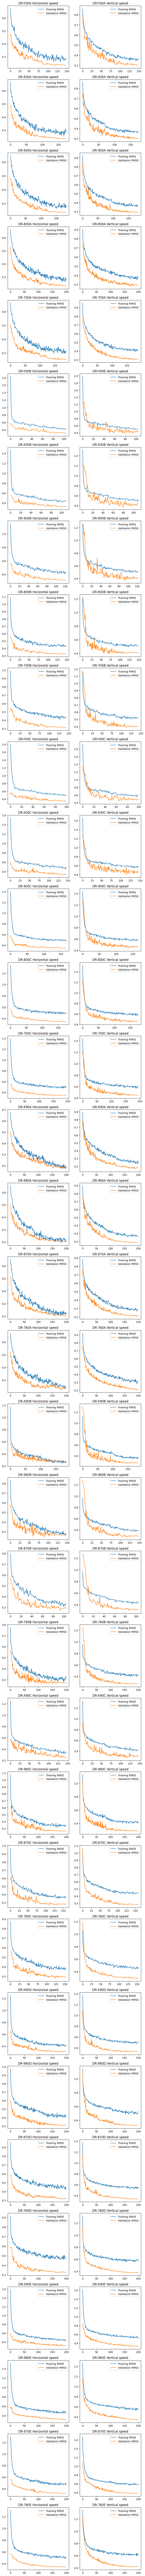

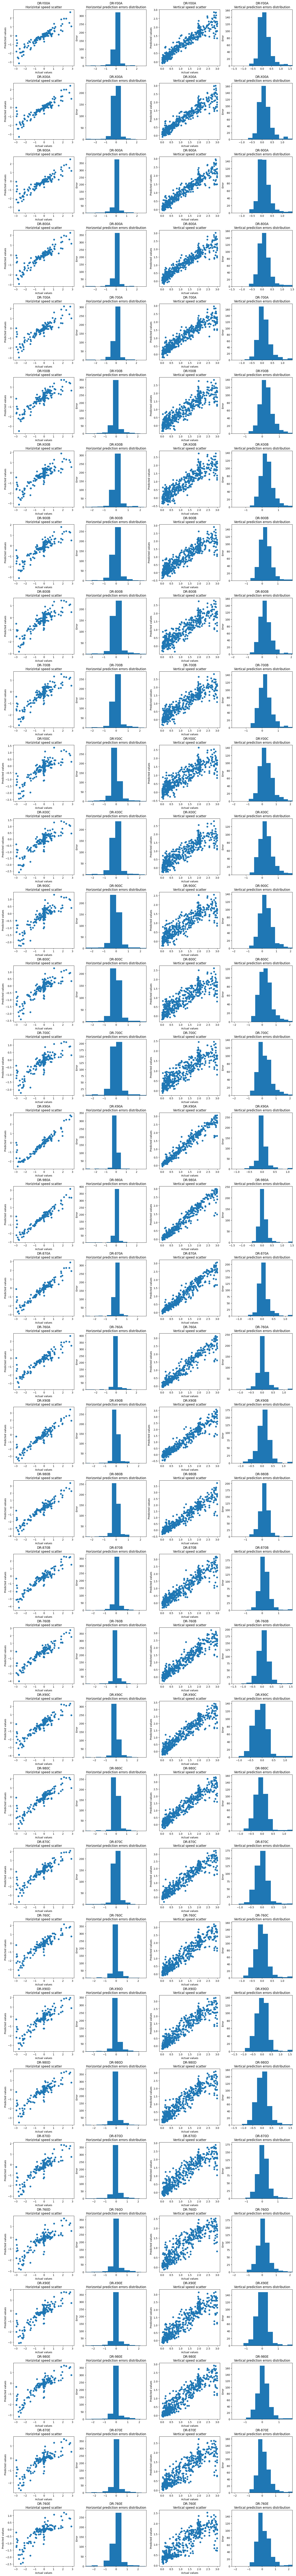

In [7]:
if os.path.exists("results"):
    shutil.rmtree("results")
os.mkdir("results")

models = [
    create_dronet(0.001, name="DR-Y00A", bottom_layers=(2024,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-X00A", bottom_layers=(1024,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-900A", bottom_layers=( 512,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-800A", bottom_layers=( 256,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-700A", bottom_layers=( 128,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-Y00B", bottom_layers=(2024,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-X00B", bottom_layers=(1024,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-900B", bottom_layers=( 512,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-800B", bottom_layers=( 256,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-700B", bottom_layers=( 128,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-Y00C", bottom_layers=(2024,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-X00C", bottom_layers=(1024,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-900C", bottom_layers=( 512,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-800C", bottom_layers=( 256,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-700C", bottom_layers=( 128,), batch_normalization_layers=(1,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-X90A", bottom_layers=(1024, 512,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-980A", bottom_layers=( 512, 256,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-870A", bottom_layers=( 256, 128,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-760A", bottom_layers=( 128,  64,), batch_normalization_layers=(), dropout_layers=()),
    create_dronet(0.001, name="DR-X90B", bottom_layers=(1024, 512,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-980B", bottom_layers=( 512, 256,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-870B", bottom_layers=( 256, 128,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-760B", bottom_layers=( 128,  64,), batch_normalization_layers=(1,), dropout_layers=()),
    create_dronet(0.001, name="DR-X90C", bottom_layers=(1024, 512,), batch_normalization_layers=(1, 2,), dropout_layers=()),
    create_dronet(0.001, name="DR-980C", bottom_layers=( 512, 256,), batch_normalization_layers=(1, 2,), dropout_layers=()),
    create_dronet(0.001, name="DR-870C", bottom_layers=( 256, 128,), batch_normalization_layers=(1, 2,), dropout_layers=()),
    create_dronet(0.001, name="DR-760C", bottom_layers=( 128,  64,), batch_normalization_layers=(1, 2,), dropout_layers=()),
    create_dronet(0.001, name="DR-X90D", bottom_layers=(1024, 512,), batch_normalization_layers=(1, 2,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-980D", bottom_layers=( 512, 256,), batch_normalization_layers=(1, 2,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-870D", bottom_layers=( 256, 128,), batch_normalization_layers=(1, 2,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-760D", bottom_layers=( 128,  64,), batch_normalization_layers=(1, 2,), dropout_layers=(1,)),
    create_dronet(0.001, name="DR-X90E", bottom_layers=(1024, 512,), batch_normalization_layers=(1, 2,), dropout_layers=(1, 2)),
    create_dronet(0.001, name="DR-980E", bottom_layers=( 512, 256,), batch_normalization_layers=(1, 2,), dropout_layers=(1, 2)),
    create_dronet(0.001, name="DR-870E", bottom_layers=( 256, 128,), batch_normalization_layers=(1, 2,), dropout_layers=(1, 2)),
    create_dronet(0.001, name="DR-760E", bottom_layers=( 128,  64,), batch_normalization_layers=(1, 2,), dropout_layers=(1, 2)),
]
    
histories = [train_model(model, train_dataset, validation_dataset) for model in tqdm(models)]

metrics = compare_models_performances(models, test_dataset)
training_history_fig = plot_training(histories)
model_comparison_fig = plot_models_comparisons(models, test_dataset)

metrics.to_csv(f"results/metrics.csv")
training_history_fig.savefig(f"results/training_history.png")
model_comparison_fig.savefig(f"results/model_comparison.png")